In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.dates as mdates

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device)) 

Using cuda device


In [ ]:
# !gdown --id '1RBb1EQIwCAv1c0J0TBrGvnF4t_oaiHq6' --output orgdata.csv

!gdown --id '1sBOT4cDsl8bLuaz4bZapUbTV0OeijAAc' --output orgdata.csv  #new
# 使用顯卡型號
# K80 < P4 < T4 < P100 <= T4(fp16) < V100
!nvidia-smi

Downloading...
From: https://drive.google.com/uc?id=1sBOT4cDsl8bLuaz4bZapUbTV0OeijAAc
To: /content/orgdata.csv
100% 132k/132k [00:00<00:00, 51.0MB/s]
Thu Jun 10 02:10:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-----------------

# 前處理

In [ ]:
import random
import numpy as np

def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(36544)

In [ ]:
path = 'orgdata.csv'
features = pd.read_csv(path)
features

,Unnamed: 0,日期,標普500,西德州,布蘭特原油,原油庫存,MSCI能源ETF價格,世界能源指數,VIX恐慌指数
0,7257,2013/10/25,1759.77,97.40,105.70,97.849998,25.000000,269.49,13.09
1,7258,2013/10/28,1762.11,98.74,108.29,98.680000,25.040001,269.36,13.31
2,7259,2013/10/29,1771.95,98.29,108.04,98.199997,25.219999,271.72,13.41
3,7260,2013/10/30,1763.31,96.81,108.41,96.769997,25.059999,271.09,13.65
4,7261,2013/10/31,1756.54,96.29,107.53,96.379997,25.000000,269.36,13.75
...,...,...,...,...,...,...,...,...,...
1863,9209,2021/4/20,4134.94,62.61,65.34,62.439999,12.680000,151.47,18.68
1864,9210,2021/4/21,4173.42,61.34,64.02,61.349998,12.870000,153.06,17.50
1865,9211,2021/4/22,4134.98,61.45,65.07,61.430000,12.700000,151.42,18.71
1866,9212,2021/4/23,4180.17,62.18,65.75,62.139999,12.840000,152.06,17.33


In [ ]:
print(np.any(np.isnan(features['原油庫存'])))
print(np.any(np.isnan(features['MSCI能源ETF價格'])))
print(np.any(np.isnan(features['世界能源指數'])))
print(np.any(np.isnan(features['VIX恐慌指数'])))


True
False
False
False


In [ ]:
index = 0
for i in range(len(features['原油庫存'])):
  if np.any(np.isnan(features['原油庫存'].iloc[i])) == True:
    features['原油庫存'].iloc[i] = features['原油庫存'].iloc[i-1]
    index += 1

In [ ]:
print(np.any(np.isnan(features['原油庫存'])))
print(np.any(np.isnan(features['MSCI能源ETF價格'])))
print(np.any(np.isnan(features['世界能源指數'])))
print(np.any(np.isnan(features['VIX恐慌指数'])))


False
False
False
False


In [ ]:
# features.drop(axis=0, columns=[features.columns[0],features.columns[2],features.columns[4],features.columns[6],features.columns[7],features.columns[8]], inplace=True)
features.drop(axis=0, columns=[features.columns[0]], inplace=True)
features.head()

,日期,標普500,西德州,布蘭特原油,原油庫存,MSCI能源ETF價格,世界能源指數,VIX恐慌指数
0,2013/10/25,1759.77,97.40,105.70,97.849998,25.000000,269.49,13.09
1,2013/10/28,1762.11,98.74,108.29,98.680000,25.040001,269.36,13.31
2,2013/10/29,1771.95,98.29,108.04,98.199997,25.219999,271.72,13.41
3,2013/10/30,1763.31,96.81,108.41,96.769997,25.059999,271.09,13.65
4,2013/10/31,1756.54,96.29,107.53,96.379997,25.000000,269.36,13.75


In [ ]:
features.shape

(1868, 8)

In [ ]:
# 時間轉換為datetime格式
date = list(features['日期'])
date_form = []

for i in date:    
    i = i.replace('/','-')
    date_form.append(i)
date_form[:10]

['2013-10-25',
 '2013-10-28',
 '2013-10-29',
 '2013-10-30',
 '2013-10-31',
 '2013-11-1',
 '2013-11-4',
 '2013-11-5',
 '2013-11-6',
 '2013-11-7']

In [ ]:
# date = datetime格式

import datetime
dates = [datetime.datetime.strptime(x, '%Y-%m-%d') for x in date_form]
dates[:5]

[datetime.datetime(2013, 10, 25, 0, 0),
 datetime.datetime(2013, 10, 28, 0, 0),
 datetime.datetime(2013, 10, 29, 0, 0),
 datetime.datetime(2013, 10, 30, 0, 0),
 datetime.datetime(2013, 10, 31, 0, 0)]

In [ ]:
features.set_index("日期")

,標普500,西德州,布蘭特原油,原油庫存,MSCI能源ETF價格,世界能源指數,VIX恐慌指数
日期,,,,,,,
2013/10/25,1759.77,97.40,105.70,97.849998,25.000000,269.49,13.09
2013/10/28,1762.11,98.74,108.29,98.680000,25.040001,269.36,13.31
2013/10/29,1771.95,98.29,108.04,98.199997,25.219999,271.72,13.41
2013/10/30,1763.31,96.81,108.41,96.769997,25.059999,271.09,13.65
2013/10/31,1756.54,96.29,107.53,96.379997,25.000000,269.36,13.75
...,...,...,...,...,...,...,...
2021/4/20,4134.94,62.61,65.34,62.439999,12.680000,151.47,18.68
2021/4/21,4173.42,61.34,64.02,61.349998,12.870000,153.06,17.50
2021/4/22,4134.98,61.45,65.07,61.430000,12.700000,151.42,18.71


# 畫圖觀察相關性

Text(0.5, 1.0, 'VIX Index')

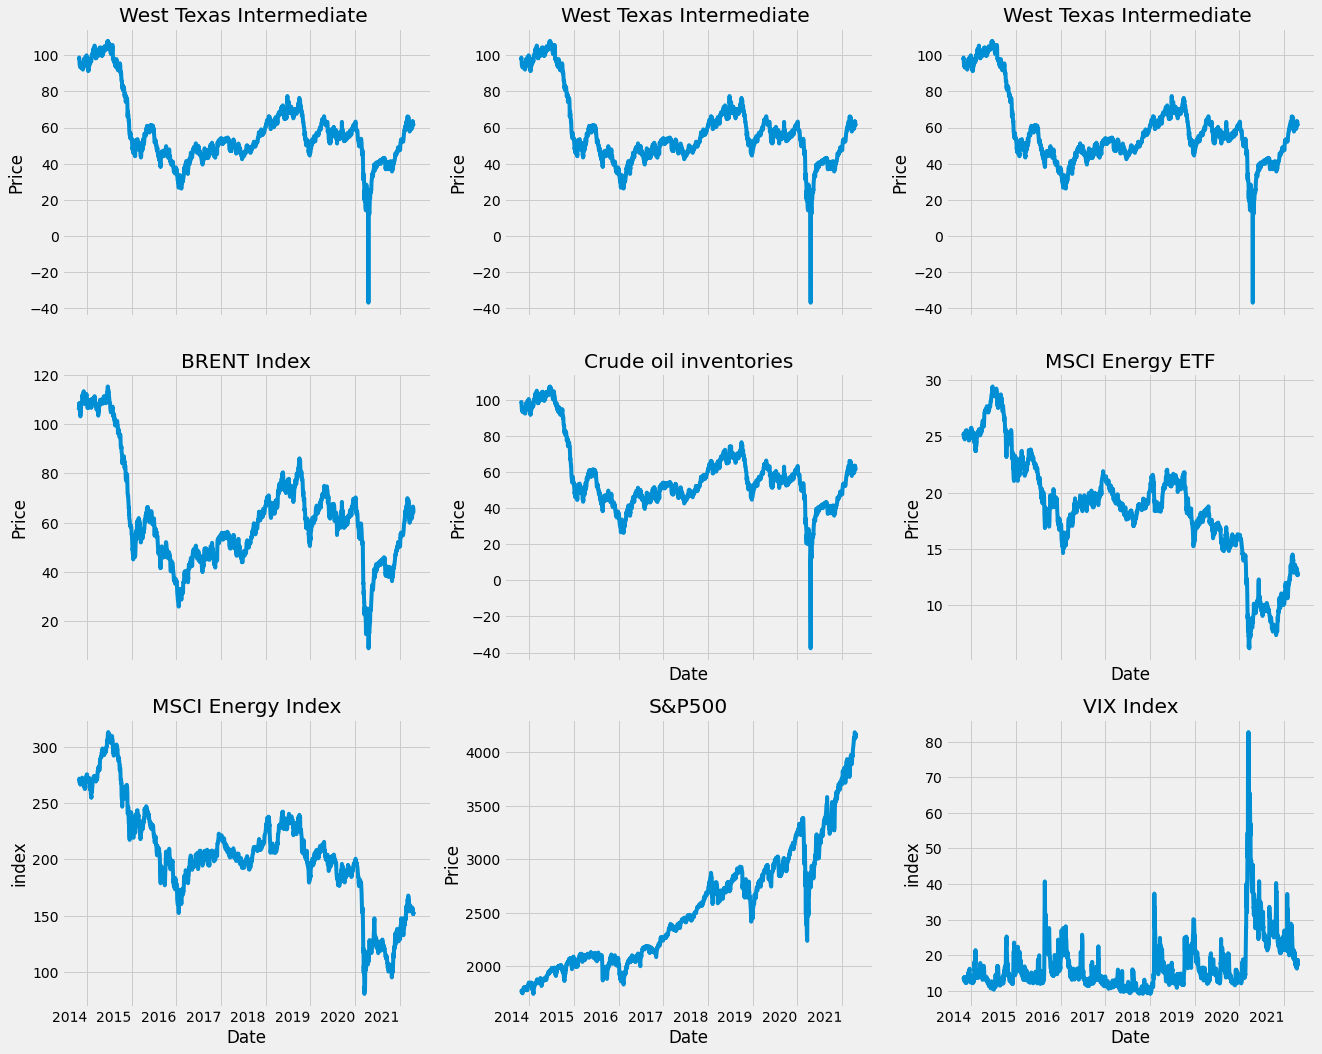

In [ ]:
# 指定風格
plt.style.use('fivethirtyeight')

# 布局
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(nrows=3, ncols=3, figsize = (20,20))
fig.autofmt_xdate(rotation = 0.5)

ax1.plot(dates, features['西德州'])
ax1.set_xlabel(''); ax1.set_ylabel('Price'); ax1.set_title('West Texas Intermediate ')


ax2.plot(dates, features['西德州'])
ax2.set_xlabel(''); ax2.set_ylabel('Price'); ax2.set_title('West Texas Intermediate ')

ax3.plot(dates, features['西德州'])
ax3.set_xlabel(''); ax3.set_ylabel('Price'); ax3.set_title('West Texas Intermediate ')

ax4.plot(dates, features['布蘭特原油'])
ax4.set_xlabel(''); ax4.set_ylabel('Price'); ax4.set_title('BRENT Index')    # 布蘭特原油指數

ax5.plot(dates, features['原油庫存'])
ax5.set_xlabel('Date'); ax5.set_ylabel('Price'); ax5.set_title('Crude oil inventories')  # 美國原油庫存

ax6.plot(dates, features['MSCI能源ETF價格'])
ax6.set_xlabel('Date'); ax6.set_ylabel('Price'); ax6.set_title('MSCI Energy ETF')    # MSCI能源ETF價格

ax7.plot(dates, features['世界能源指數'])
ax7.set_xlabel('Date'); ax7.set_ylabel('index'); ax7.set_title('MSCI Energy Index')  # 世界能源指數

ax8.plot(dates, features['標普500'])
ax8.set_xlabel('Date'); ax8.set_ylabel('Price'); ax8.set_title('S&P500')  # S&P500

ax9.plot(dates, features['VIX恐慌指数'])
ax9.set_xlabel('Date'); ax9.set_ylabel('index'); ax9.set_title('VIX Index') # VIX恐慌指数

In [ ]:
features_process = features.iloc[:,1:]
features_process

,標普500,西德州,布蘭特原油,原油庫存,MSCI能源ETF價格,世界能源指數,VIX恐慌指数
0,1759.77,97.40,105.70,97.849998,25.000000,269.49,13.09
1,1762.11,98.74,108.29,98.680000,25.040001,269.36,13.31
2,1771.95,98.29,108.04,98.199997,25.219999,271.72,13.41
3,1763.31,96.81,108.41,96.769997,25.059999,271.09,13.65
4,1756.54,96.29,107.53,96.379997,25.000000,269.36,13.75
...,...,...,...,...,...,...,...
1863,4134.94,62.61,65.34,62.439999,12.680000,151.47,18.68
1864,4173.42,61.34,64.02,61.349998,12.870000,153.06,17.50
1865,4134.98,61.45,65.07,61.430000,12.700000,151.42,18.71
1866,4180.17,62.18,65.75,62.139999,12.840000,152.06,17.33


In [ ]:
df_features = features_process
# df_features = features[['西德州']]
df_features1 = df_features[['西德州']]
df_features2 = df_features[['布蘭特原油']]
df_features3 = df_features[['原油庫存']]
df_features4 = df_features[['標普500']]
df_features5 = df_features[['MSCI能源ETF價格']]
df_features6 = df_features[['世界能源指數']]
df_features7 = df_features[['VIX恐慌指数']]

# 標準化每個features

In [ ]:
from sklearn.preprocessing import MinMaxScaler
df_features1 = df_features1.fillna(method = 'ffill')
df_features2 = df_features2.fillna(method = 'ffill')
df_features3 = df_features3.fillna(method = 'ffill')
df_features4 = df_features4.fillna(method = 'ffill')
df_features5 = df_features5.fillna(method = 'ffill')
df_features6 = df_features6.fillna(method = 'ffill')
df_features7 = df_features7.fillna(method = 'ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))

scaler1 = MinMaxScaler(feature_range=(-1, 1))
df_features['西德州'] = scaler1.fit_transform(df_features['西德州'].values.reshape(-1,1))

scaler_2 = MinMaxScaler(feature_range=(-1, 1))
df_features['布蘭特原油'] = scaler_2.fit_transform(df_features['布蘭特原油'].values.reshape(-1,1))

scaler_3 = MinMaxScaler(feature_range=(-1, 1))
df_features['原油庫存'] = scaler_3.fit_transform(df_features['原油庫存'].values.reshape(-1,1))

scaler_4 = MinMaxScaler(feature_range=(-1, 1))
df_features['標普500'] = scaler_4.fit_transform(df_features['標普500'].values.reshape(-1,1))

scaler_5 = MinMaxScaler(feature_range=(-1, 1))
df_features['MSCI能源ETF價格'] = scaler_5.fit_transform(df_features['MSCI能源ETF價格'].values.reshape(-1,1))

scaler_6 = MinMaxScaler(feature_range=(-1, 1))
df_features['世界能源指數'] = scaler_6.fit_transform(df_features['世界能源指數'].values.reshape(-1,1))

scaler_7 = MinMaxScaler(feature_range=(-1, 1))
df_features['VIX恐慌指数'] = scaler_7.fit_transform(df_features['VIX恐慌指数'].values.reshape(-1,1))

# 設定Hyperparameter

In [ ]:
from torch import optim
import torch as t

#-------for LSTM formula--------------#
look_back = 60 # 用前幾天的資料預測下一天

#-------for networks--------------#
hidden_feature_dim = 32  # LSTM神經元個數
hidden_layer_num = 2 # LSTM的層數
classes_num = 1 # 輸出幾筆資料
dropout = 0.01
bidirectional = False #LSTM通道數 ( True or False )
batch_first = True # 不能動

#-------for training--------------#
learning_rate = 0.001
batch_size = 1 # 不能動
epoch = 1000



# 變數選擇


In [ ]:
# 標普500(1)	西德州(2)	布蘭特原油(3)	原油庫存(4)	MSCI能源ETF價格(5)	世界能源指數(6)	VIX恐慌指数(7) #看要丟掉那些變數
df_features.drop(axis=0, columns=[features.columns[1], features.columns[3], features.columns[4], features.columns[5], features.columns[6], features.columns[7]], inplace=True)
# df_features['西德州']  

# divide Training and validation 

In [ ]:
def load_data(stock, n_timestamp, true, dates):

    data_raw = stock.values # convert to numpy array
    data = [] # for whole test
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - n_timestamp): 
        data.append(data_raw[index: index + n_timestamp])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    train_set_size_list = train_set_size + n_timestamp

    train_dates = dates[:train_set_size]
    test_dates = dates[train_set_size_list:]
    train_true = true[:train_set_size]
    test_true = true[train_set_size_list:]
    
    x_all = data[:,:-1,:]

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_all, x_train, y_train, x_test, y_test, data, train_true, test_true, train_dates, test_dates]


x_all, x_train, y_train, x_test, y_test, data, train_true, test_true, train_dates, test_dates = load_data(df_features, look_back, df_features1, dates)

print('x_all.shape = ',x_all.shape)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)
print('train_true.shape = ',train_true.shape)
print('test_true.shape = ',test_true.shape)
print('train_dates.shape = ',len(train_dates))
print('test_dates.shape = ',len(test_dates))

x_all.shape =  (1808, 59, 1)
x_train.shape =  (1446, 59, 1)
y_train.shape =  (1446, 1)
x_test.shape =  (362, 59, 1)
y_test.shape =  (362, 1)
train_true.shape =  (1446, 1)
test_true.shape =  (362, 1)
train_dates.shape =  1446
test_dates.shape =  362


# LSTM層的輸入必須是三維的。這輸入的三個維度是： (seq_len, batch, input_size) 沒有batch_first

reference
1. https://zhenglungwu.medium.com/pytorch%E5%AF%A6%E4%BD%9Clstm%E5%9F%B7%E8%A1%8C%E8%A8%8A%E8%99%9F%E9%A0%90%E6%B8%AC-d1d3f17549e7

2. https://clay-atlas.com/blog/2020/05/12/pytorch-lstm-%E7%9A%84%E5%8E%9F%E7%90%86%E8%88%87%E8%BC%B8%E5%85%A5%E8%BC%B8%E5%87%BA%E6%A0%BC%E5%BC%8F%E7%B4%80%E9%8C%84/

3. https://blog.csdn.net/comli_cn/article/details/105275827

4. https://www.itread01.com/content/1549911976.html

5. https://www.kaggle.com/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch


In [ ]:
# 格式轉換 Tensor
x_all, x_train, x_valid, y_train, y_valid = np.array(x_all), np.array(x_train),np.array(x_test),np.array(y_train),np.array(y_test)
x_all, x_train, x_valid, y_train, y_valid = torch.tensor(x_all, dtype = torch.float), torch.tensor(x_train, dtype = torch.float), torch.tensor(x_valid, dtype = torch.float), torch.tensor(y_train, dtype = torch.float), torch.tensor(y_valid, dtype = torch.float)

print(x_train.shape,type(x_train))
print(y_train.shape,type(y_train))
print(x_valid.shape,type(x_valid))
print(y_valid.shape,type(y_valid))
print(x_all.shape,type(x_all))


torch.Size([1446, 59, 1]) <class 'torch.Tensor'>
torch.Size([1446, 1]) <class 'torch.Tensor'>
torch.Size([362, 59, 1]) <class 'torch.Tensor'>
torch.Size([362, 1]) <class 'torch.Tensor'>
torch.Size([1808, 59, 1]) <class 'torch.Tensor'>


In [ ]:
y_train.size(),x_train.size()

(torch.Size([1446, 1]), torch.Size([1446, 59, 1]))

In [ ]:
# feature放進GPU
x_train = x_train.to(device)
y_train = y_train.to(device)
x_valid = x_valid.to(device)
y_valid = y_valid.to(device)

# 建立模型

In [ ]:
class WTI_LSTM(nn.Module):
#建立LSTM class
    # def __init__(self, input_feature_dim, hidden_feature_dim, hidden_layer_num, dropout, bidirectional=bidirectional):
    def __init__(self, input_feature_dim, hidden_feature_dim, hidden_layer_num, batch_first=batch_first):
        super(WTI_LSTM,self).__init__()
        self.input_feature_dim = input_feature_dim
        self.hidden_feature_dim = hidden_feature_dim
        self.hidden_layer_num = hidden_layer_num
        self.batch_first = batch_first
        self.batch_size = batch_size
        self.dropout = dropout
        self.bidirectional = bidirectional

        # self.lstm=nn.LSTM(input_feature_dim, hidden_feature_dim, hidden_layer_num, dropout, bidirectional=bidirectional)   #初始化LSTM 目前為單向(若要雙向則加上bidirectional) 
        self.lstm=nn.LSTM(input_feature_dim, hidden_feature_dim, hidden_layer_num, batch_first=batch_first)
        self.linear1=nn.Linear(hidden_feature_dim,1)# FNN
    
   

       
    def forward(self,x):
        h0 = torch.zeros(self.hidden_layer_num, x.size(0), self.hidden_feature_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.hidden_layer_num, x.size(0), self.hidden_feature_dim).requires_grad_().to(device)
        output,(hn,cn)=self.lstm(x, (h0.detach(), c0.detach()))  
        output=self.linear1(output[:, -1, :])         
        return output,(hn,cn)


# 定義RMSE

In [ ]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

# 訓練model的參數定義

In [ ]:
input_feature_dim = x_train.shape[2] # 變數有幾個

model = WTI_LSTM(input_feature_dim, hidden_feature_dim, hidden_layer_num, batch_first=batch_first).to(device)
#-------for optimizer and evaluation--------------#
opt = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = RMSELoss()

In [ ]:
def train(x_train, y_train, hist):
    model.train()
    # n_timestamp = look_back-1
    pred,(hn,cn) = model(x_train)

    loss = loss_func(pred, y_train.to(device))

    hist[t] = loss.item()
    # Zero out gradient, else they will accumulate between epochs
    opt.zero_grad()
    # Backward pass
    loss.backward()
    # Update parameters
    opt.step()
    return pred, loss, hist[t]

In [ ]:
def test(x_test, y_test, hist_val):
    model.eval()  # 關閉batchnormaliztion和dropout
    # n_timestamp = look_back-1
    predict_val,(hn,cn) = model(x_test)

    loss_val = loss_func(predict_val , y_test)
    hist_val[t] = loss.item()

    return predict_val, loss_val, hist_val[t]

In [ ]:
# Train model
#####################  0.1651

hist = np.zeros(epoch)
hist_val = np.zeros(epoch)

# Number of steps to unroll


t = 0
for t in range(epoch):
  pred, loss, hist[t] = train(x_train, y_train, hist)
  predict_val, loss_val, hist_val[t] = test(x_valid, y_valid, hist_val)
  t += 1
  if (t) % 10 == 0:
    print(f'epoch:{t}  -------  loss:{loss.item():.4f}  -------  valid_loss:{loss_val.item():.4f}')  

model.train(False)

epoch:10  -------  loss:0.2705  -------  valid_loss:0.2083
epoch:20  -------  loss:0.2488  -------  valid_loss:0.3097
epoch:30  -------  loss:0.2298  -------  valid_loss:0.2427
epoch:40  -------  loss:0.2013  -------  valid_loss:0.2415
epoch:50  -------  loss:0.0785  -------  valid_loss:0.1484
epoch:60  -------  loss:0.0638  -------  valid_loss:0.1392
epoch:70  -------  loss:0.0539  -------  valid_loss:0.1147
epoch:80  -------  loss:0.0483  -------  valid_loss:0.1043
epoch:90  -------  loss:0.0424  -------  valid_loss:0.0879
epoch:100  -------  loss:0.0381  -------  valid_loss:0.0807
epoch:110  -------  loss:0.0350  -------  valid_loss:0.0761
epoch:120  -------  loss:0.0325  -------  valid_loss:0.0710
epoch:130  -------  loss:0.0301  -------  valid_loss:0.0659
epoch:140  -------  loss:0.0286  -------  valid_loss:0.0619
epoch:150  -------  loss:0.0280  -------  valid_loss:0.0603
epoch:160  -------  loss:0.0275  -------  valid_loss:0.0597
epoch:170  -------  loss:0.0270  -------  valid_l

WTI_LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:

pred,(hn,cn) = model(x_train)
pred

tensor([[0.8064],
        [0.8255],
        [0.8437],
        ...,
        [0.2579],
        [0.2699],
        [0.2834]], device='cuda:0', grad_fn=<AddmmBackward>)

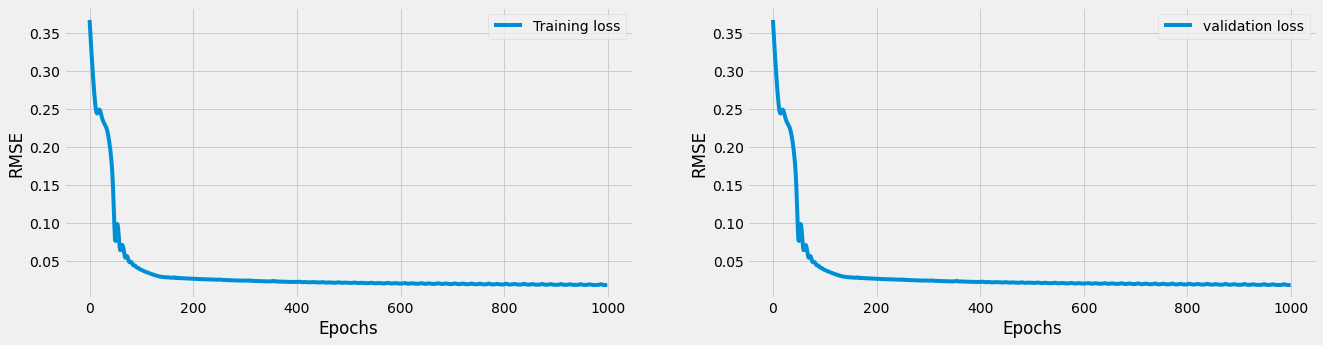

In [ ]:
plt.subplots(figsize=(20,5))

plt.subplot(1,2,1)
plt.ylabel("RMSE")
plt.xlabel("Epochs")
plt.plot(hist, label="Training loss")
plt.legend()

plt.subplot(1,2,2)
plt.ylabel("RMSE")
plt.xlabel("Epochs")
plt.plot(hist_val, label="validation loss")
plt.legend()

# inference

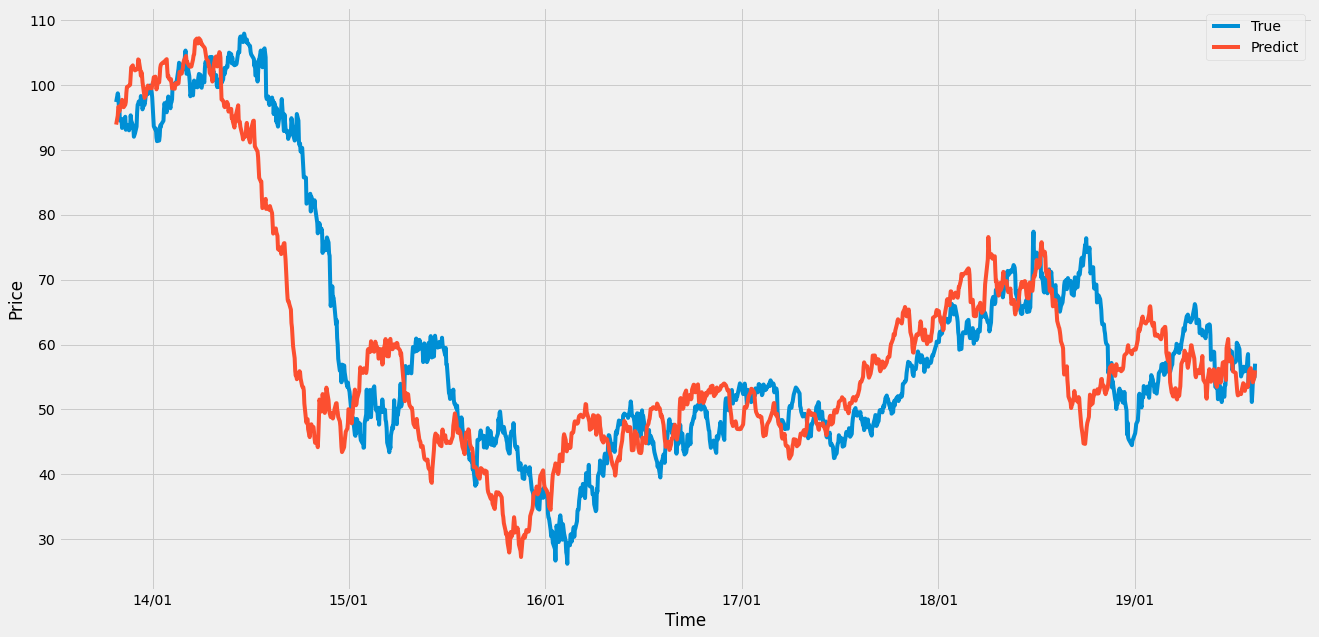

In [ ]:
# Training data 訓練結果
plt.subplots(figsize=(20,10))
pred,(hn,cn) = model(x_train)
plt.ylabel("Price")
plt.xlabel("Time")
pred = scaler1.inverse_transform(pred.detach().cpu().numpy())
pred_list = [] #pred to list
for i in pred:
  pred_list.append(i[0])

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))
plt.plot(train_dates,train_true, label="True")
plt.plot(train_dates,pred_list, label="Predict")

plt.legend()

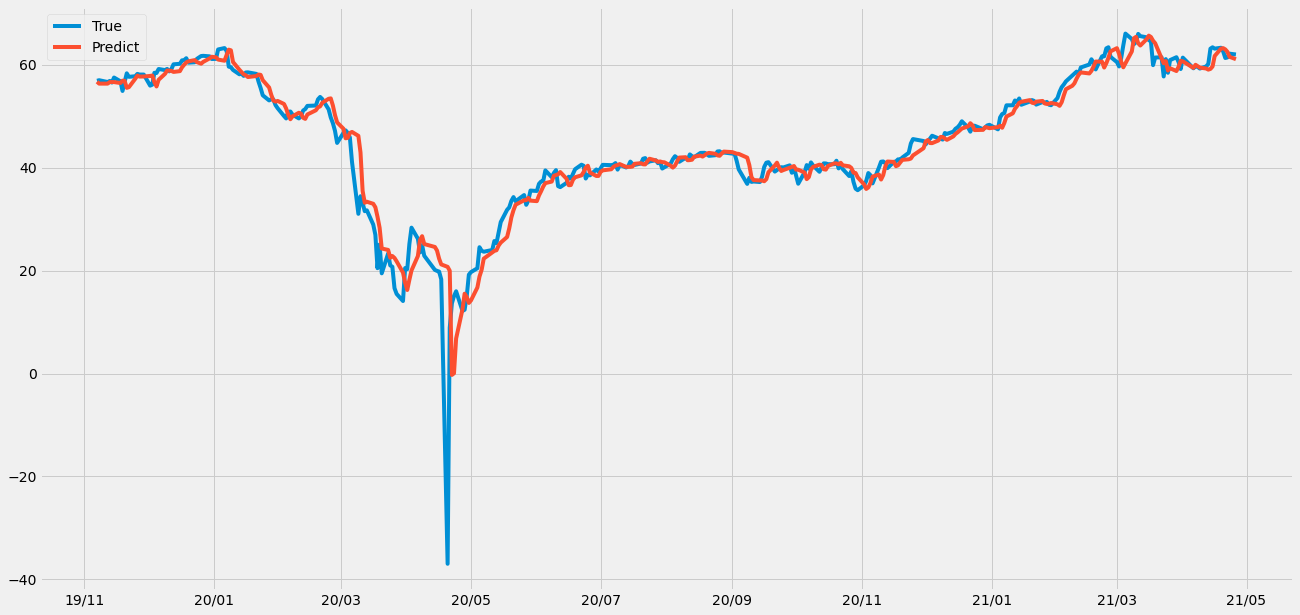

In [ ]:
# Testing data訓練結果
plt.subplots(figsize=(20,10))
pred,(hn,cn) = model(x_valid)
pred = scaler1.inverse_transform(pred.detach().cpu().numpy())
pred_list = [] #pred to list
for i in pred:
  pred_list.append(i[0])

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))
plt.plot(test_dates, test_true, label="True")
plt.plot(test_dates, pred_list, label="Predict")

plt.legend()

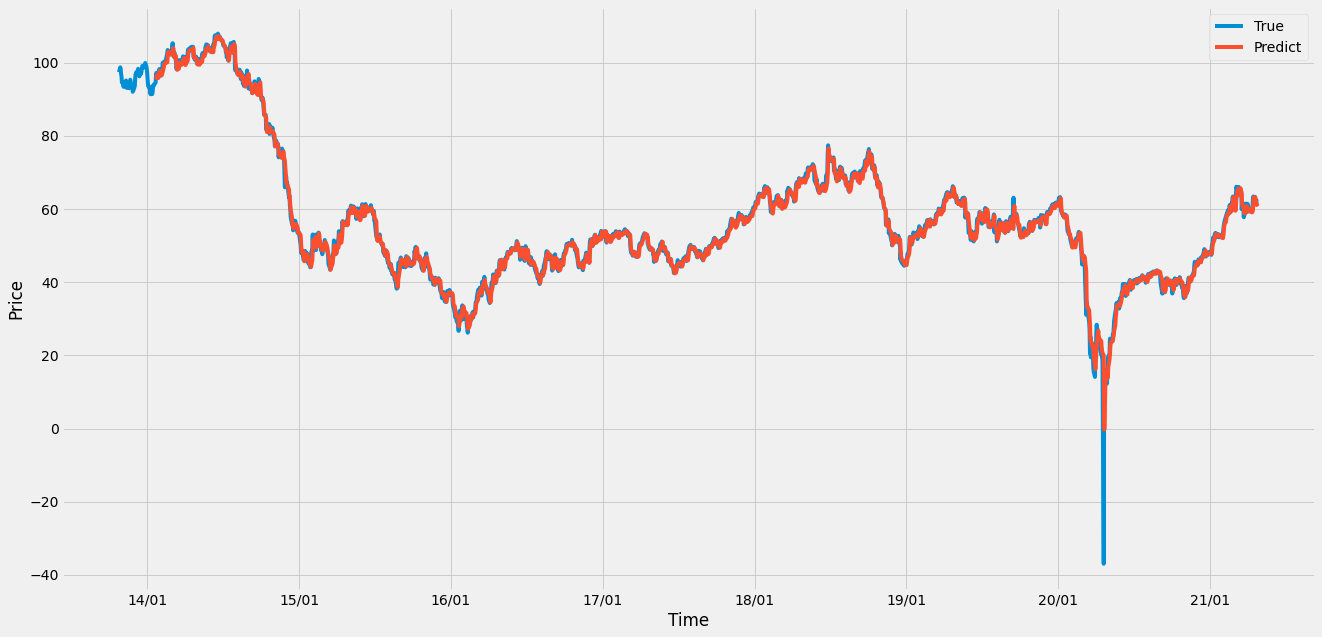

In [ ]:
# 全期訓練結果

plt.subplots(figsize=(20,10))
data = torch.tensor(data, dtype = torch.float)

pred,(hn,cn) = model(data.to(device))
plt.ylabel("Price")
plt.xlabel("Time")
pred = scaler1.inverse_transform(pred.detach().cpu().numpy())

pred_list = [] #pred to list
for i in pred:
  pred_list.append(i[0])

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))

plt.plot(dates, df_features1, label="True")

plt.plot(dates[look_back:], pred_list,  label="Predict")

plt.legend()

In [ ]:
data.shape

torch.Size([1808, 60, 1])